During the pre-pre-alignment workflow I estimate library size. I can be expected that a high quality sample should have a minimum library size of say 1 million reads. By looking at library sizes I can exclude potentially problematic samples with very low number of reads.

In [1]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('notebook')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)


last updated: 2017-09-26 
Git hash: db5dd6c127e957b2eb686579f7d9fb7c0f2b1235


In [2]:
# %load ../../bin/load.py
from pymongo import MongoClient
with open('/home/fearjm/Projects/ncbi_remap/output/.mongodb_host', 'r') as fh:
    host = fh.read().strip()
client = MongoClient(host=host, port=27022)
db = client['sra2']
remap = db['remap']


In [3]:
# Query DB and get read information.

## Quick count for sanity
num_runs = list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'},
            ]
        }
    },
    {'$count': 'cnt'}
]))[0]['cnt']

In [4]:
# Make read information dataframes

## Single End
dfSE = pd.DataFrame(list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'},
                {'runs.pre_aln_flags': 'SE'},
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'libsize': {
                '$cond': [
                    {'$in': ['keep_R2', '$runs.pre_aln_flags']}, 
                    '$runs.libsize.R2',
                    '$runs.libsize.R1'
                ]
            },
            'len': {
                '$cond': [
                    {'$in': ['keep_R2', '$runs.pre_aln_flags']}, 
                    '$runs.avgReadLen.R2',
                    '$runs.avgReadLen.R1'
                ]
            },
            'hisat_num_reads': '$runs.pre_aln_workflow.hisat2.num_reads',
        }
    },
])))

## Pair End 
dfPE = pd.DataFrame(list(remap.aggregate([ {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'},
                {'runs.pre_aln_flags': 'PE'},
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'libsize_R1': '$runs.libsize.R1',
            'libsize_R2': '$runs.libsize.R2',
            'len_R1': '$runs.avgReadLen.R1',
            'len_R2': '$runs.avgReadLen.R2',
            'hisat_num_reads': '$runs.pre_aln_workflow.hisat2.num_reads',
        }
    },
])))

## Make sure read 1 equals read 2. The pipeline should drop 
## unpaired reads so they should be the same
assert (dfPE.libsize_R1 == dfPE.libsize_R2).all()

## only keep R1 for easier matching with SE data.
dfPE.drop('libsize_R2', axis=1, inplace=True)
dfPE.drop('len_R2', axis=1, inplace=True)
dfPE.rename(columns={'libsize_R1': 'libsize', 'len_R1': 'len'}, inplace=True)

# concat SE and PE
df = pd.concat([dfSE, dfPE])
df.set_index(['srx', 'srr'], inplace=True)

# Test that we have all of the completed samples.
assert num_runs == df.shape[0]

# Library Size

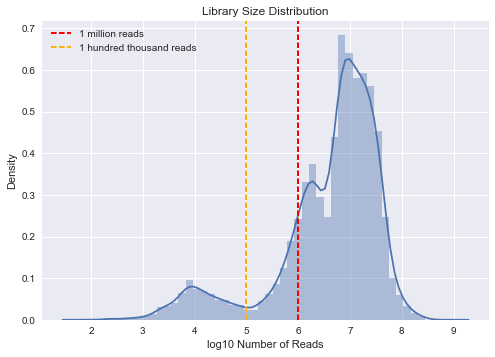

In [5]:
# plot distribution of library size
ax = sns.distplot(np.log10(df.libsize))
ax.axvline(np.log10(1e6), ls='--', lw=2, color='r', label='1 million reads')
ax.axvline(np.log10(1e5), ls='--', lw=2, color=sns.xkcd_rgb['amber'], label='1 hundred thousand reads')
ax.legend()
ax.set_xlabel('log10 Number of Reads')
ax.set_ylabel('Density')
ax.set_title('Library Size Distribution');

In [6]:
# Add flags for low library size
df['flag_low_libsize'] = False
df.loc[df.libsize < 1e5, 'flag_low_libsize'] = True

In [7]:
# How many samples are filtered with this flag?
df.flag_low_libsize.sum()

2102

# Read Length

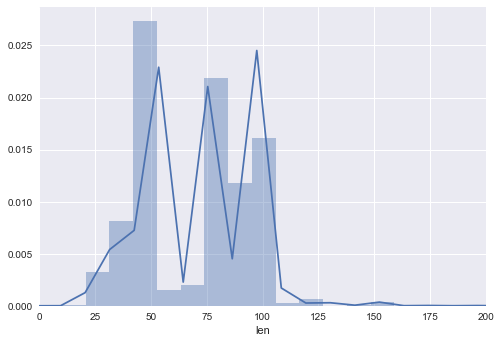

In [13]:
# plot distribution of read lengths
ax = sns.distplot(df.len, bins=100)
ax.set_xlim(0, 200);

In [20]:
# make flags for short reads
df['flag_short_read_len'] = False
df.loc[df.len < 30, 'flag_short_read_len'] = True

In [21]:
# How many samples do we lose with short reads
df.flag_short_read_len.sum()

697